In [1]:
%load_ext autoreload
%autoreload 2

# Visualise the 2 circuits for ruggedness

In [2]:
import os
import numpy as np
import json
from matplotlib import pyplot as plt
import seaborn as sns
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import create_network_inset, make_nx_weights
from evoscaper.run.ruggedness import add_original


In [3]:
# dir_rugg = 'data/ruggedness/2025_07_02__11_24_20'
# dir_rugg = 'data/ruggedness/2025_07_02__13_25_02'
# dir_rugg = 'data/ruggedness/2025_07_02__14_14_21'
dir_rugg = 'data/ruggedness/2025_07_31__14_30_21'  # curves look different AGAIN but tolerably
dir_rugg = 'data/ruggedness/2025_07_31__15_37_32'  # sanity check with n_samples = 3 
dir_rugg = 'data/ruggedness/2025_07_31__15_43_46'  # draw eps from normal
dir_rugg = 'data/ruggedness/2025_09_17__11_58_58'  # new pair

ys = np.load(os.path.join(dir_rugg, 'batch_0', 'ys.npy'))
ts = np.load(os.path.join(dir_rugg, 'batch_0', 'ts.npy'))
t_max_show = 2000
t_max_i = np.where(ts < t_max_show)[-1][-1]
config_rugg = load_json_as_dict(os.path.join(dir_rugg, 'config.json'))
interactions = np.concatenate([np.load(fn.replace('notebooks/', ''))[None, :] for fn in config_rugg['fn_circuits']], axis=0)
# eps = np.load(os.path.join(dir_rugg, 'batch_0', 'eps.npy'))
# perturbations = interactions[:, None, :] + eps
# perturbations = add_original(perturbations, interactions, config_rugg['resimulate_analytics'])
# perturbations.shape


In [4]:
top_write_dir = os.path.join(
    'data', '19_visualise_rugged_latents', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
config = {'dir_rugg': dir_rugg}
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)

In [5]:
resimulate_analytics = config.get('resimulate_analytics', False)
n_samples = 2
n_perturbs = ys.shape[0] // n_samples
idx_output = -1
ys = ys.reshape(n_samples, n_perturbs, ys.shape[-2], ys.shape[-1])


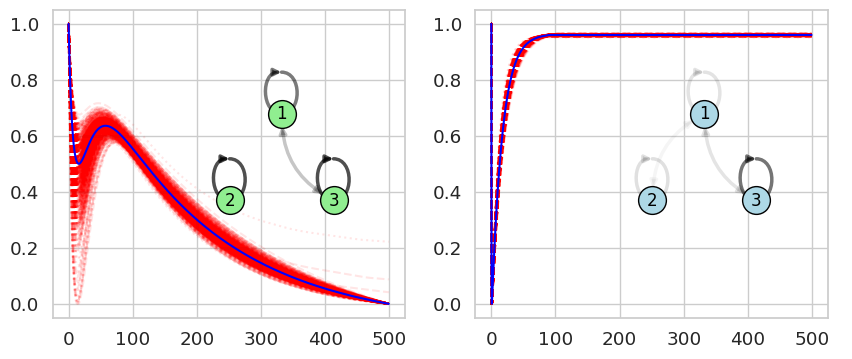

In [6]:
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid')

fig, axs = plt.subplots(1, n_samples, figsize=(5 * n_samples, 4), sharex=True)

for i_samp, pos in zip(range(n_samples), [(0.2, 0.1), (0.2, 0.1)]):
    ax = axs[i_samp]

    for crugg in np.concatenate([np.arange(100), np.arange(n_perturbs - 800, n_perturbs)]): #n_perturbs):

        is_og = crugg == (n_perturbs -1)
        
        ys_p = ys[i_samp, crugg, :t_max_i + 1, idx_output]
        ys_p = np.interp(ys_p, (ys_p.min(), ys_p.max()), (0, 1))
        sns.lineplot(x=ts[:t_max_i + 1], y=ys_p,
                     ax=ax, alpha=1 if is_og else 0.1,
                     linestyle=('--' if np.mod(crugg, 2) == 0 else 'dotted') if not(is_og) else '-',
                     color='b' if is_og else 'r')
        
        
    w = interactions[i_samp]
    create_network_inset(fig, ax, pos=pos, width=0.9, height=0.9, edge_weights=make_nx_weights(w, n_nodes=3, vmin=-30, vmax=0),
                        node_color='lightgreen' if i_samp == 0 else 'lightblue', linewidth=2.5)

    # ax.set_title(f'Sample {i_samp + 1}') # ({config["fn_circuits"][i_samp].split("_")[-1].split(".")[0] })')
plt.savefig(os.path.join(top_write_dir, 'ys_sample.png'), dpi=300, bbox_inches='tight')